In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

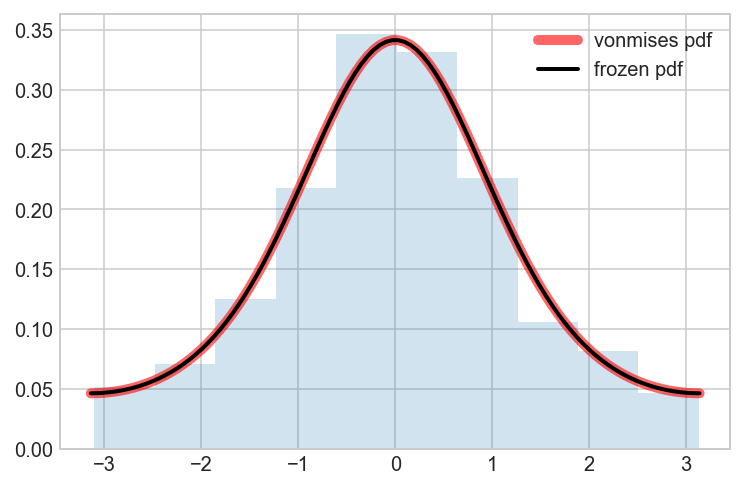

In [3]:
from scipy import stats
from scipy.stats import vonmises, vonmises_line
# https://en.wikipedia.org/wiki/Von_Mises_distribution
# Von MIsses
fig, ax = plt.subplots(1, 1)

kappa = 1

x = np.linspace(vonmises.ppf(0.0001, kappa),
                vonmises.ppf(0.9999, kappa), 100)
ax.plot(x, vonmises.pdf(x, kappa),
       'r-', lw=5, alpha=0.6, label='vonmises pdf')


rv = vonmises(kappa)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

r = vonmises.rvs(kappa, size=1000)

ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

[-3.14159265e+00 -1.57079633e+00  2.22044605e-16  1.57079633e+00
  3.14159265e+00]


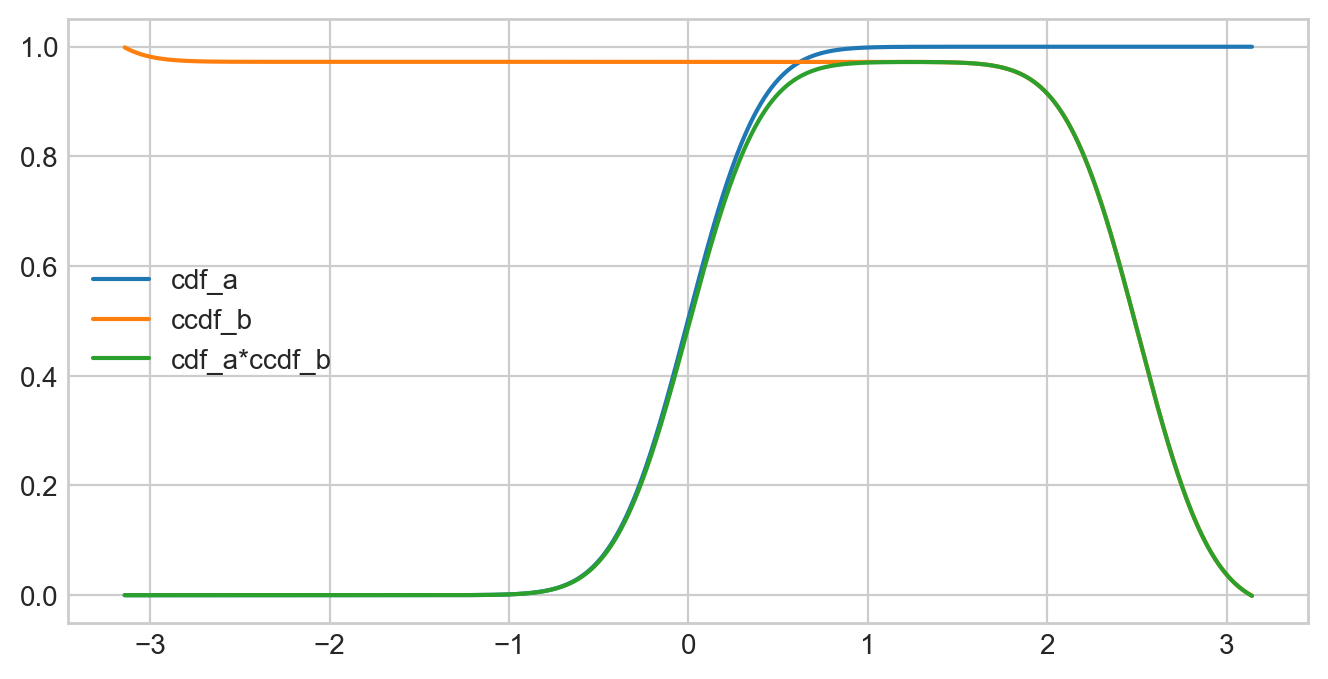

In [2]:
import scipy
import scipy.integrate as integrate

pi = np.pi
# fig, ax = plt.subplots(1, 1)
t = np.linspace(0,1,1000)

t0 = 0

t = -pi +2*pi*((t-t0)) 
print(np.percentile(t, (0,25,50,75,100)))
a = 0

# a = 

b = 0.8*pi

kappa =10
def vonMisesPdf(x,mu,kappa):
    return np.exp(kappa*(np.cos(x-mu)))/(2*pi*scipy.special.i0(kappa))

pdf_a = vonMisesPdf(t,mu=a,kappa=kappa)
cdf_a = np.cumsum(pdf_a)*((t[-1]-t[0])/(len(t)-1))

pdf_b = vonMisesPdf(t,mu=b,kappa=kappa)
cdf_b = np.cumsum(pdf_b)*((t[-1]-t[0])/(len(t)-1))
ccdf_b = 1-np.cumsum(pdf_b)*((t[-1]-t[0])/(len(t)-1))


fig, ax= plt.subplots(1,1 ,figsize=(8,4),dpi=100)
ax.plot(t,cdf_a,label="cdf_a")
ax.plot(t,ccdf_b,label="ccdf_b")
ax.plot(t,cdf_a*ccdf_b,label="cdf_a*ccdf_b")
plt.legend()

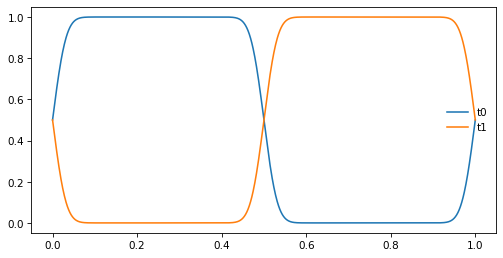

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
# import rvlib # https://github.com/QuantEcon/rvlib
import numba

def phaseIndicator(t,t0,a,b,sigma):
    t_ = ((t - t0)%1)*2.-1. # map [0,1]->[-1,1]
#     ndist_a = rvlib.Normal(mu=a*2.-1.,sigma=sigma)
    ndist_a = stats.norm(a*2.-1.,sigma)
#     cdf_a = ndist_a.cdf(t_)
    cdf_a = (ndist_a.cdf(t_)-ndist_a.cdf(-1))/(ndist_a.cdf(1)-ndist_a.cdf(-1))
#     ndist_b = rvlib.Normal(mu=b*2.-1.,sigma=sigma)
    ndist_b = stats.norm(b*2.-1.,sigma)
    ccdf_b = 1- (ndist_b.cdf(t_)-ndist_b.cdf(-1))/(ndist_b.cdf(1)-ndist_b.cdf(-1))
#     ccdf_b = ndist_b.ccdf(t_)
    return cdf_a*ccdf_b


t = np.linspace(0,1,1000)
a = 0.25
b = 0.75
sigma = 0.05
t0 = 0.75
t1 = 0.25

e_i0 = phaseIndicator(t,t0,a,b,sigma)
e_i1 = phaseIndicator(t,t1,a,b,sigma)

fig, ax= plt.subplots(1,1 ,figsize=(8,4),dpi=75)

ax.plot(t,e_i0,label="t0")
ax.plot(t,e_i1,label="t1")

plt.legend(loc='best', frameon=False)

In [3]:
import numpy as np
import numba

@numba.njit(nogil=True,fastmath=True,cache=True)
def logistic_cdf(x,mu,s):
    return 1/(1+np.exp(-(x-mu)/s))

@numba.njit(nogil=True,fastmath=True,cache=True)
def phaseIndicator(t,t0,a,b,s):
    """
    phase indicator function with logistic distribution
    ref: https://en.wikipedia.org/wiki/Logistic_distribution
    Input:
        t:  normalized phase [0-1]
        t0: phase offset [0-1]
        a:  mean [0-1]
        b:  mean [0-1]
        s:  variance [0-1]
    returns:
        phase indicator
    """
    t_ = ((t - t0)%1)*2.-1. # map [0,1]->[-1,1]
    mu_a = a*2.-1.
    # cumulative distribution function
    cdf_a = (logistic_cdf(t_,mu_a,s)- logistic_cdf(-1,mu_a,s))/(logistic_cdf(1,mu_a,s) - logistic_cdf(-1,mu_a,s))
    mu_b = b*2.-1.
    # complementary cumulative distribution function
    ccdf_b = 1-(logistic_cdf(t_,mu_b,s)- logistic_cdf(-1,mu_b,s))/(logistic_cdf(1,mu_b,s) - logistic_cdf(-1,mu_b,s))
    return cdf_a*ccdf_b

@numba.experimental.jitclass([
    ("a", numba.float32),
    ("b", numba.float32),
    ("s", numba.float32),
    ("t0", numba.float32),
    ("t1", numba.float32),
])
class phaseIndicatorPair:
    def __init__(self,a,b,s,t0,t1):
        """ create a parir of phase indicator
        Args:
            a # separation point for increasing from 0 -> 1
            b # separation point for decreasing from 1 -> 0
            s # sigma, shared variance
            t0 # normlaized phase offset [0-1] for the 1st value in the pair
            t1 # normlaized phase offset [0-1] for the 2nd value in the pair 
        """
        
        self.a = a # separation point for increasing from 0 -> 1
        self.b = b # separation point for decreasing from 1 -> 0
        self.s = s # variance
        self.t0 = t0 # normlaized phase offset [0-1] for the 1st value in the pair
        self.t1 = t1 # normlaized phase offset [0-1] for the 2nd value in the pair
    def get(self,t):
        """ return a pair of phase indicator values give noramlized time t"""
        return phaseIndicator(t,self.t0,self.a,self.b,self.s),phaseIndicator(t,self.t1,self.a,self.b,self.s)
    

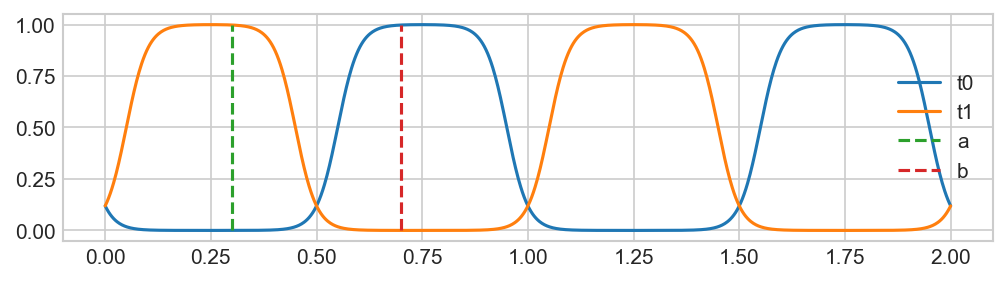

In [10]:
t = np.linspace(0,2,1000)
a = 0.3
b = 0.7
s = 0.05

t0 = 0.25
t1 = 0.75

# e_i0 = phaseIndicator(t,t0,a,b,s)
# e_i1 = phaseIndicator(t,t1,a,b,s)

phase_indicator_pair = phaseIndicatorPair(a,b,s,t0,t1)
# t = np.linspace(0,2,1000)

e_i0,e_i1 = phase_indicator_pair.get(t)

fig, ax= plt.subplots(1,1 ,figsize=(8,2),dpi=75)
ax.plot(t,e_i0,label="t0")
ax.plot(t,e_i1,label="t1")
ax.plot([a,a],[0,1],'--',label='a')
ax.plot([b,b],[0,1],'--',label='b')
plt.legend(loc='best', frameon=False)

In [9]:
%timeit e_i = phaseIndicator(t,t0,a,b,sigma)

21.8 µs ± 443 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
# tcn

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from collections import OrderedDict



####

class SinActivation(nn.Module):
    def __init__(self,omega=30.):
        super().__init__() # init the base class
        self.omega = omega
    def forward(self, input):
        return torch.sin(self.omega*input)

####

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

    def __repr__(self):
        return f"Chomp1d(chomp_size={self.chomp_size})"

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                          stride=stride, padding=padding, dilation=dilation))
        conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # self.net = nn.Sequential(conv1, chomp1, relu1, dropout1,
        #                          conv2, chomp2, relu2, dropout2)  
        self.net = nn.Sequential(OrderedDict([
            ("conv1",   conv1),
            ("chomp1",  Chomp1d(padding)),
            ("relu1",   nn.ReLU()),
            ("dropout1",nn.Dropout(dropout)),
            ("conv2",   conv2),
            ("chomp2",  Chomp1d(padding)),
            ("relu2",   nn.ReLU()),
            ("dropout2",nn.Dropout(dropout))
        ]))
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
#         self.relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.net.conv1.weight.data.normal_(0, 0.01)
        self.net.conv2.weight.data.normal_(0, 0.01)
#         self.conv1.weight.data.normal_(0, 0.01)
#         self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [48]:
self = TemporalConvNet(2,[2])

In [49]:
print(self)

TemporalConvNet(
  (network): Sequential(
    (0): TemporalBlock(
      (net): Sequential(
        (conv1): Conv1d(2, 2, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d(chomp_size=1)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(2, 2, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d(chomp_size=1)
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (relu): ReLU()
    )
  )
)


In [50]:
############################ model

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])
    
######################### utils

import torch
import numpy as np
from torch.autograd import Variable

def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in range(N):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return X,Y
#     return Variable(X), Variable(Y)


######################### main

import torch
import argparse
import torch.optim as optim
import torch.nn.functional as F
import sys


parser = argparse.ArgumentParser(description='Sequence Modeling - The Adding Problem')
parser.add_argument('--batch_size', type=int, default=32, metavar='N',
                    help='batch size (default: 32)')
parser.add_argument('--cuda', action='store_false',
                    help='use CUDA (default: True)')
parser.add_argument('--dropout', type=float, default=0.0,
                    help='dropout applied to layers (default: 0.0)')
parser.add_argument('--clip', type=float, default=-1,
                    help='gradient clip, -1 means no clip (default: -1)')
parser.add_argument('--epochs', type=int, default=10,
                    help='upper epoch limit (default: 10)')
parser.add_argument('--ksize', type=int, default=7,
                    help='kernel size (default: 7)')
parser.add_argument('--levels', type=int, default=8,
                    help='# of levels (default: 8)')
parser.add_argument('--seq_len', type=int, default=400,
                    help='sequence length (default: 400)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='report interval (default: 100')
parser.add_argument('--lr', type=float, default=4e-3,
                    help='initial learning rate (default: 4e-3)')
parser.add_argument('--optim', type=str, default='Adam',
                    help='optimizer to use (default: Adam)')
parser.add_argument('--nhid', type=int, default=30,
                    help='number of hidden units per layer (default: 30)')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed (default: 1111)')
args = parser.parse_args("")

torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs

print(args)
print("Producing data...")
X_train, Y_train = data_generator(50000, seq_length)
X_test, Y_test = data_generator(1000, seq_length)


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

Namespace(batch_size=32, clip=-1, cuda=True, dropout=0.0, epochs=10, ksize=7, levels=8, log_interval=100, lr=0.004, nhid=30, optim='Adam', seed=1111, seq_len=400)
Producing data...
Train Epoch:  1 [  3168/ 50000 (6%)]	Learning rate: 0.0040	Loss: 0.345950
Train Epoch:  1 [  6368/ 50000 (13%)]	Learning rate: 0.0040	Loss: 0.169880
Train Epoch:  1 [  9568/ 50000 (19%)]	Learning rate: 0.0040	Loss: 0.169092
Train Epoch:  1 [ 12768/ 50000 (26%)]	Learning rate: 0.0040	Loss: 0.167055
Train Epoch:  1 [ 15968/ 50000 (32%)]	Learning rate: 0.0040	Loss: 0.170597
Train Epoch:  1 [ 19168/ 50000 (38%)]	Learning rate: 0.0040	Loss: 0.169619
Train Epoch:  1 [ 22368/ 50000 (45%)]	Learning rate: 0.0040	Loss: 0.168802
Train Epoch:  1 [ 25568/ 50000 (51%)]	Learning rate: 0.0040	Loss: 0.176612
Train Epoch:  1 [ 28768/ 50000 (58%)]	Learning rate: 0.0040	Loss: 0.167222
Train Epoch:  1 [ 31968/ 50000 (64%)]	Learning rate: 0.0040	Loss: 0.163598
Train Epoch:  1 [ 35168/ 50000 (70%)]	Learning rate: 0.0040	Loss: 0.16


Test set: Average loss: 0.000070

Train Epoch:  8 [  3168/ 50000 (6%)]	Learning rate: 0.0040	Loss: 0.000593
Train Epoch:  8 [  6368/ 50000 (13%)]	Learning rate: 0.0040	Loss: 0.000421
Train Epoch:  8 [  9568/ 50000 (19%)]	Learning rate: 0.0040	Loss: 0.000229
Train Epoch:  8 [ 12768/ 50000 (26%)]	Learning rate: 0.0040	Loss: 0.000243
Train Epoch:  8 [ 15968/ 50000 (32%)]	Learning rate: 0.0040	Loss: 0.000144
Train Epoch:  8 [ 19168/ 50000 (38%)]	Learning rate: 0.0040	Loss: 0.000150
Train Epoch:  8 [ 22368/ 50000 (45%)]	Learning rate: 0.0040	Loss: 0.000320
Train Epoch:  8 [ 25568/ 50000 (51%)]	Learning rate: 0.0040	Loss: 0.000347
Train Epoch:  8 [ 28768/ 50000 (58%)]	Learning rate: 0.0040	Loss: 0.000211
Train Epoch:  8 [ 31968/ 50000 (64%)]	Learning rate: 0.0040	Loss: 0.000707
Train Epoch:  8 [ 35168/ 50000 (70%)]	Learning rate: 0.0040	Loss: 0.000802
Train Epoch:  8 [ 38368/ 50000 (77%)]	Learning rate: 0.0040	Loss: 0.000135
Train Epoch:  8 [ 41568/ 50000 (83%)]	Learning rate: 0.0040	Loss: 

In [49]:
[args.nhid]*args.levels

[30, 30, 30, 30, 30, 30, 30, 30]

In [48]:
X_test.shape

torch.Size([1000, 2, 400])

In [ ]:
for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

In [53]:
torch.save(model.state_dict(),"./saved_model_tcn.torch")

In [68]:
X_test[0,0]@X_test[0,1] - Y_test[0]

tensor([0.], device='cuda:0')

In [70]:
X_test[0,0]@X_test[0,1]-Y_test[0]

tensor([0.], device='cuda:0')

In [2]:
import numpy as np
import torch
import os
import msgpack
import tqdm
from pytorch_sac.replay_buffer import ReplayBuffer

In [3]:
device = "cuda:1"

replay_buffer = ReplayBuffer(1,(1,),(1,),device=device)
replay_buffer.load("exp//True_2021.08.29.1013//replay_buffer")

In [5]:
%timeit _ = replay_buffer.sample(1)

651 µs ± 8.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
obs.reshape((batch_size,-1,5)).shape

torch.Size([2, 63, 5])

In [8]:
from pytorch_sac.utils import mlp, weight_init

device = "cuda:1"

state_dim = 63
history_size = 10
action_dim = 12
hidden_dim = 128

batch_size = 2048

class Model(nn.Module):
    def __init__(self,
                 state_dim=state_dim,
                 action_dim=action_dim,
                 num_channels=[hidden_dim]*3,
                 kernel_size=2,
                 dropout=0
                 ):
        super().__init__()
        self.tcn = TemporalConvNet(num_inputs=state_dim, num_channels=num_channels,
                                   kernel_size=kernel_size, dropout=dropout)
        self.mlp = mlp(input_dim= num_channels[-1]*2 + action_dim,
                       hidden_channels=[hidden_dim]*3,
                       output_dim=state_dim)
        self.apply(weight_init)

    def forward(self, state, action):
        x1 = self.tcn(state)
#         print(x1.shape,action.shape)
        x = torch.cat((x1[:, :, -2],x1[:, :, -1], action), dim=1)
        return self.mlp(x)
    
    def train_step(self, optimizer, criterion, dataset,batch_size, training=True):
        obs, action, reward, next_obs, not_done, not_done_no_max = dataset.sample(batch_size)
        
        #    forward dynamics
        s1_pred = self(obs.reshape((batch_size,-1,history_size)), action)
        s1 = next_obs.reshape((batch_size,-1,history_size))[:,:,0]
        loss = criterion(s1_pred, s1)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss
    
model = Model().to(device)

In [9]:
def countParameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(countParameters(model))

382271


In [10]:
from prettytable import PrettyTable

def countParameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

countParameters(model)

+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     tcn.network.0.conv1.bias    |    128     |
|   tcn.network.0.conv1.weight_g  |    128     |
|   tcn.network.0.conv1.weight_v  |   16128    |
|     tcn.network.0.conv2.bias    |    128     |
|   tcn.network.0.conv2.weight_g  |    128     |
|   tcn.network.0.conv2.weight_v  |   32768    |
| tcn.network.0.downsample.weight |    8064    |
|  tcn.network.0.downsample.bias  |    128     |
|     tcn.network.1.conv1.bias    |    128     |
|   tcn.network.1.conv1.weight_g  |    128     |
|   tcn.network.1.conv1.weight_v  |   32768    |
|     tcn.network.1.conv2.bias    |    128     |
|   tcn.network.1.conv2.weight_g  |    128     |
|   tcn.network.1.conv2.weight_v  |   32768    |
|     tcn.network.2.conv1.bias    |    128     |
|   tcn.network.2.conv1.weight_g  |    128     |
|   tcn.network.2.conv1.weight_v  |   32768    |
|     tcn.network.2.

382271

In [190]:
# print(model)

In [13]:
obs, action, reward, next_obs, not_done, not_done_no_max = replay_buffer.sample(batch_size)
model(state = obs.reshape((batch_size,-1,history_size)), action=action)

tensor([[ 0.1432,  0.6461,  0.0708,  ..., -0.4777,  0.2737,  0.2468],
        [ 0.0587,  0.4186,  0.1386,  ..., -0.5021,  0.0620,  0.2254],
        [ 0.0883,  0.4794, -0.0419,  ..., -0.6734,  0.3442, -0.0159],
        ...,
        [ 0.2314,  0.3788,  0.2651,  ..., -0.3168, -0.0295,  0.1908],
        [ 0.0084,  0.5842,  0.0342,  ..., -0.4506, -0.1320,  0.1811],
        [ 0.1632,  0.4664,  0.1137,  ..., -0.4107,  0.0172, -0.2618]],
       device='cuda:1', grad_fn=<AddmmBackward>)

In [14]:
from tqdm.notebook import tqdm
# Reset random seeds
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
criterion = nn.L1Loss() # https://pytorch.org/docs/stable/nn.html#loss-functions
# criterion = weightedL1Loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=np.sqrt(0.5),min_lr=1e-5,verbose=True)

model.train()
torch.set_grad_enabled(True)

n_batch = 2048
for batch in tqdm(range(n_batch)):

    train_loss = model.train_step(optimizer, criterion, replay_buffer,batch_size)
    print(f"batch {batch}: train:{train_loss:.3f}", )

  0%|          | 0/2048 [00:00<?, ?it/s]

batch 0: train:0.388
batch 1: train:0.302
batch 2: train:0.249
batch 3: train:0.200
batch 4: train:0.171
batch 5: train:0.169
batch 6: train:0.149
batch 7: train:0.144
batch 8: train:0.145
batch 9: train:0.142
batch 10: train:0.135
batch 11: train:0.129
batch 12: train:0.123
batch 13: train:0.120
batch 14: train:0.117
batch 15: train:0.116
batch 16: train:0.115
batch 17: train:0.112
batch 18: train:0.109
batch 19: train:0.106
batch 20: train:0.105
batch 21: train:0.104
batch 22: train:0.101
batch 23: train:0.100
batch 24: train:0.099
batch 25: train:0.099
batch 26: train:0.096
batch 27: train:0.094
batch 28: train:0.094
batch 29: train:0.095
batch 30: train:0.092
batch 31: train:0.092
batch 32: train:0.090
batch 33: train:0.089
batch 34: train:0.089
batch 35: train:0.088
batch 36: train:0.086
batch 37: train:0.086
batch 38: train:0.085
batch 39: train:0.085
batch 40: train:0.083
batch 41: train:0.084
batch 42: train:0.082
batch 43: train:0.080
batch 44: train:0.080
batch 45: train:0.08

batch 361: train:0.033
batch 362: train:0.030
batch 363: train:0.032
batch 364: train:0.032
batch 365: train:0.031
batch 366: train:0.034
batch 367: train:0.031
batch 368: train:0.031
batch 369: train:0.032
batch 370: train:0.033
batch 371: train:0.031
batch 372: train:0.033
batch 373: train:0.032
batch 374: train:0.035
batch 375: train:0.031
batch 376: train:0.032
batch 377: train:0.032
batch 378: train:0.032
batch 379: train:0.031
batch 380: train:0.032
batch 381: train:0.031
batch 382: train:0.032
batch 383: train:0.032
batch 384: train:0.031
batch 385: train:0.033
batch 386: train:0.032
batch 387: train:0.032
batch 388: train:0.032
batch 389: train:0.031
batch 390: train:0.032
batch 391: train:0.033
batch 392: train:0.031
batch 393: train:0.033
batch 394: train:0.032
batch 395: train:0.033
batch 396: train:0.031
batch 397: train:0.033
batch 398: train:0.031
batch 399: train:0.033
batch 400: train:0.032
batch 401: train:0.032
batch 402: train:0.032
batch 403: train:0.030
batch 404: 

batch 718: train:0.027
batch 719: train:0.025
batch 720: train:0.026
batch 721: train:0.025
batch 722: train:0.025
batch 723: train:0.025
batch 724: train:0.025
batch 725: train:0.026
batch 726: train:0.025
batch 727: train:0.025
batch 728: train:0.025
batch 729: train:0.025
batch 730: train:0.025
batch 731: train:0.025
batch 732: train:0.027
batch 733: train:0.025
batch 734: train:0.026
batch 735: train:0.025
batch 736: train:0.026
batch 737: train:0.024
batch 738: train:0.025
batch 739: train:0.024
batch 740: train:0.025
batch 741: train:0.024
batch 742: train:0.026
batch 743: train:0.024
batch 744: train:0.025
batch 745: train:0.024
batch 746: train:0.025
batch 747: train:0.025
batch 748: train:0.025
batch 749: train:0.025
batch 750: train:0.025
batch 751: train:0.024
batch 752: train:0.026
batch 753: train:0.025
batch 754: train:0.024
batch 755: train:0.024
batch 756: train:0.026
batch 757: train:0.025
batch 758: train:0.025
batch 759: train:0.025
batch 760: train:0.025
batch 761: 

batch 1072: train:0.024
batch 1073: train:0.024
batch 1074: train:0.025
batch 1075: train:0.024
batch 1076: train:0.025
batch 1077: train:0.026
batch 1078: train:0.025
batch 1079: train:0.028
batch 1080: train:0.024
batch 1081: train:0.028
batch 1082: train:0.024
batch 1083: train:0.027
batch 1084: train:0.024
batch 1085: train:0.025
batch 1086: train:0.026
batch 1087: train:0.024
batch 1088: train:0.025
batch 1089: train:0.024
batch 1090: train:0.024
batch 1091: train:0.025
batch 1092: train:0.023
batch 1093: train:0.025
batch 1094: train:0.025
batch 1095: train:0.024
batch 1096: train:0.024
batch 1097: train:0.024
batch 1098: train:0.023
batch 1099: train:0.023
batch 1100: train:0.023
batch 1101: train:0.023
batch 1102: train:0.024
batch 1103: train:0.023
batch 1104: train:0.024
batch 1105: train:0.023
batch 1106: train:0.024
batch 1107: train:0.024
batch 1108: train:0.024
batch 1109: train:0.024
batch 1110: train:0.023
batch 1111: train:0.024
batch 1112: train:0.025
batch 1113: trai

batch 1414: train:0.020
batch 1415: train:0.021
batch 1416: train:0.021
batch 1417: train:0.021
batch 1418: train:0.021
batch 1419: train:0.020
batch 1420: train:0.021
batch 1421: train:0.021
batch 1422: train:0.020
batch 1423: train:0.020
batch 1424: train:0.021
batch 1425: train:0.020
batch 1426: train:0.024
batch 1427: train:0.021
batch 1428: train:0.020
batch 1429: train:0.021
batch 1430: train:0.022
batch 1431: train:0.021
batch 1432: train:0.021
batch 1433: train:0.023
batch 1434: train:0.021
batch 1435: train:0.022
batch 1436: train:0.022
batch 1437: train:0.020
batch 1438: train:0.022
batch 1439: train:0.021
batch 1440: train:0.022
batch 1441: train:0.021
batch 1442: train:0.023
batch 1443: train:0.020
batch 1444: train:0.022
batch 1445: train:0.021
batch 1446: train:0.022
batch 1447: train:0.021
batch 1448: train:0.021
batch 1449: train:0.020
batch 1450: train:0.022
batch 1451: train:0.022
batch 1452: train:0.021
batch 1453: train:0.022
batch 1454: train:0.021
batch 1455: trai

batch 1756: train:0.018
batch 1757: train:0.018
batch 1758: train:0.018
batch 1759: train:0.019
batch 1760: train:0.019
batch 1761: train:0.018
batch 1762: train:0.018
batch 1763: train:0.018
batch 1764: train:0.019
batch 1765: train:0.019
batch 1766: train:0.019
batch 1767: train:0.018
batch 1768: train:0.018
batch 1769: train:0.019
batch 1770: train:0.019
batch 1771: train:0.019
batch 1772: train:0.019
batch 1773: train:0.018
batch 1774: train:0.019
batch 1775: train:0.018
batch 1776: train:0.019
batch 1777: train:0.018
batch 1778: train:0.018
batch 1779: train:0.020
batch 1780: train:0.019
batch 1781: train:0.019
batch 1782: train:0.019
batch 1783: train:0.019
batch 1784: train:0.020
batch 1785: train:0.019
batch 1786: train:0.019
batch 1787: train:0.018
batch 1788: train:0.019
batch 1789: train:0.019
batch 1790: train:0.020
batch 1791: train:0.019
batch 1792: train:0.018
batch 1793: train:0.018
batch 1794: train:0.019
batch 1795: train:0.019
batch 1796: train:0.019
batch 1797: trai

KeyboardInterrupt: 

In [15]:
from pytorch_sac.utils import mlp, weight_init

device = "cuda:1"

state_dim = 63
history_size = 10

action_dim = 12
hidden_dim = 128

batch_size = 2048

class ModelBase(nn.Module):
    def __init__(self,
                 state_dim=state_dim,
                 action_dim=action_dim,
                 num_channels=[hidden_dim]*6,
                 ):
        super().__init__()
        self.mlp = mlp(input_dim= state_dim*history_size + action_dim,
                       hidden_channels=num_channels,
                       output_dim=state_dim)
        self.apply(weight_init)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        return self.mlp(x)
    
    def train_step(self, optimizer, criterion, dataset,batch_size, training=True):
        obs, action, reward, next_obs, not_done, not_done_no_max = dataset.sample(batch_size)
        
        #    forward dynamics
        s1_pred = self(obs, action)
        s1 = next_obs.reshape((batch_size,-1,history_size))[:,:,0]
        loss = criterion(s1_pred, s1)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss
    
model = ModelBase().to(device)

In [16]:
countParameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| mlp.0.blocks.0.weight |   82176    |
|  mlp.0.blocks.0.bias  |    128     |
| mlp.0.blocks.2.weight |   16384    |
|  mlp.0.blocks.2.bias  |    128     |
| mlp.0.shortcut.weight |   82176    |
|  mlp.0.shortcut.bias  |    128     |
| mlp.1.blocks.0.weight |   16384    |
|  mlp.1.blocks.0.bias  |    128     |
| mlp.1.blocks.2.weight |   16384    |
|  mlp.1.blocks.2.bias  |    128     |
| mlp.1.shortcut.weight |   16384    |
|  mlp.1.shortcut.bias  |    128     |
| mlp.2.blocks.0.weight |   16384    |
|  mlp.2.blocks.0.bias  |    128     |
| mlp.2.blocks.2.weight |   16384    |
|  mlp.2.blocks.2.bias  |    128     |
| mlp.2.shortcut.weight |   16384    |
|  mlp.2.shortcut.bias  |    128     |
| mlp.3.blocks.0.weight |   16384    |
|  mlp.3.blocks.0.bias  |    128     |
| mlp.3.blocks.2.weight |   16384    |
|  mlp.3.blocks.2.bias  |    128     |
| mlp.3.shortcut.weight |

436927

In [17]:
from tqdm.notebook import tqdm
# Reset random seeds
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
criterion = nn.L1Loss() # https://pytorch.org/docs/stable/nn.html#loss-functions
# criterion = weightedL1Loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=np.sqrt(0.5),min_lr=1e-5,verbose=True)

model.train()
torch.set_grad_enabled(True)

n_batch = 2048
for batch in tqdm(range(n_batch)):

    train_loss = model.train_step(optimizer, criterion, replay_buffer,batch_size)
    print(f"batch {batch}: train:{train_loss:.3f}", )

  0%|          | 0/2048 [00:00<?, ?it/s]

batch 0: train:1.389
batch 1: train:0.670
batch 2: train:0.431
batch 3: train:0.339
batch 4: train:0.307
batch 5: train:0.282
batch 6: train:0.256
batch 7: train:0.240
batch 8: train:0.228
batch 9: train:0.214
batch 10: train:0.201
batch 11: train:0.189
batch 12: train:0.174
batch 13: train:0.163
batch 14: train:0.157
batch 15: train:0.153
batch 16: train:0.149
batch 17: train:0.141
batch 18: train:0.135
batch 19: train:0.129
batch 20: train:0.122
batch 21: train:0.116
batch 22: train:0.112
batch 23: train:0.111
batch 24: train:0.107
batch 25: train:0.105
batch 26: train:0.098
batch 27: train:0.094
batch 28: train:0.092
batch 29: train:0.092
batch 30: train:0.088
batch 31: train:0.086
batch 32: train:0.083
batch 33: train:0.080
batch 34: train:0.078
batch 35: train:0.075
batch 36: train:0.074
batch 37: train:0.073
batch 38: train:0.071
batch 39: train:0.069
batch 40: train:0.064
batch 41: train:0.065
batch 42: train:0.063
batch 43: train:0.061
batch 44: train:0.061
batch 45: train:0.06

batch 362: train:0.031
batch 363: train:0.031
batch 364: train:0.034
batch 365: train:0.031
batch 366: train:0.031
batch 367: train:0.031
batch 368: train:0.031
batch 369: train:0.029
batch 370: train:0.031
batch 371: train:0.031
batch 372: train:0.032
batch 373: train:0.030
batch 374: train:0.030
batch 375: train:0.031
batch 376: train:0.028
batch 377: train:0.027
batch 378: train:0.029
batch 379: train:0.029
batch 380: train:0.028
batch 381: train:0.028
batch 382: train:0.028
batch 383: train:0.028
batch 384: train:0.027
batch 385: train:0.029
batch 386: train:0.026
batch 387: train:0.028
batch 388: train:0.028
batch 389: train:0.027
batch 390: train:0.028
batch 391: train:0.029
batch 392: train:0.028
batch 393: train:0.027
batch 394: train:0.028
batch 395: train:0.029
batch 396: train:0.029
batch 397: train:0.027
batch 398: train:0.030
batch 399: train:0.029
batch 400: train:0.027
batch 401: train:0.029
batch 402: train:0.030
batch 403: train:0.028
batch 404: train:0.029
batch 405: 

batch 720: train:0.024
batch 721: train:0.023
batch 722: train:0.023
batch 723: train:0.023
batch 724: train:0.023
batch 725: train:0.023
batch 726: train:0.023
batch 727: train:0.024
batch 728: train:0.022
batch 729: train:0.023
batch 730: train:0.024
batch 731: train:0.023
batch 732: train:0.024
batch 733: train:0.022
batch 734: train:0.023
batch 735: train:0.024
batch 736: train:0.025
batch 737: train:0.023
batch 738: train:0.026
batch 739: train:0.025
batch 740: train:0.025
batch 741: train:0.023
batch 742: train:0.026
batch 743: train:0.026
batch 744: train:0.026
batch 745: train:0.026
batch 746: train:0.025
batch 747: train:0.026
batch 748: train:0.025
batch 749: train:0.028
batch 750: train:0.024
batch 751: train:0.026
batch 752: train:0.026
batch 753: train:0.025
batch 754: train:0.024
batch 755: train:0.024
batch 756: train:0.024
batch 757: train:0.024
batch 758: train:0.025
batch 759: train:0.025
batch 760: train:0.022
batch 761: train:0.024
batch 762: train:0.025
batch 763: 

batch 1078: train:0.022
batch 1079: train:0.024
batch 1080: train:0.022
batch 1081: train:0.022
batch 1082: train:0.023
batch 1083: train:0.023
batch 1084: train:0.022
batch 1085: train:0.024
batch 1086: train:0.023
batch 1087: train:0.022
batch 1088: train:0.024
batch 1089: train:0.023
batch 1090: train:0.024
batch 1091: train:0.024
batch 1092: train:0.023
batch 1093: train:0.022
batch 1094: train:0.024
batch 1095: train:0.023
batch 1096: train:0.022
batch 1097: train:0.022
batch 1098: train:0.022
batch 1099: train:0.023
batch 1100: train:0.021
batch 1101: train:0.022
batch 1102: train:0.021
batch 1103: train:0.021
batch 1104: train:0.021
batch 1105: train:0.020
batch 1106: train:0.021
batch 1107: train:0.022
batch 1108: train:0.021
batch 1109: train:0.021
batch 1110: train:0.021
batch 1111: train:0.019
batch 1112: train:0.021
batch 1113: train:0.021
batch 1114: train:0.019
batch 1115: train:0.021
batch 1116: train:0.020
batch 1117: train:0.020
batch 1118: train:0.020
batch 1119: trai

batch 1424: train:0.018
batch 1425: train:0.018
batch 1426: train:0.019
batch 1427: train:0.018
batch 1428: train:0.019
batch 1429: train:0.018
batch 1430: train:0.018
batch 1431: train:0.018
batch 1432: train:0.017
batch 1433: train:0.018
batch 1434: train:0.018
batch 1435: train:0.018
batch 1436: train:0.018
batch 1437: train:0.019
batch 1438: train:0.018
batch 1439: train:0.018
batch 1440: train:0.017
batch 1441: train:0.018
batch 1442: train:0.019
batch 1443: train:0.018
batch 1444: train:0.018
batch 1445: train:0.018
batch 1446: train:0.018
batch 1447: train:0.018
batch 1448: train:0.018
batch 1449: train:0.019
batch 1450: train:0.018
batch 1451: train:0.018
batch 1452: train:0.018
batch 1453: train:0.018
batch 1454: train:0.017
batch 1455: train:0.017
batch 1456: train:0.019
batch 1457: train:0.018
batch 1458: train:0.018
batch 1459: train:0.018
batch 1460: train:0.017
batch 1461: train:0.019
batch 1462: train:0.018
batch 1463: train:0.017
batch 1464: train:0.020
batch 1465: trai

batch 1766: train:0.017
batch 1767: train:0.018
batch 1768: train:0.018
batch 1769: train:0.015
batch 1770: train:0.019
batch 1771: train:0.018
batch 1772: train:0.018
batch 1773: train:0.017
batch 1774: train:0.016
batch 1775: train:0.017
batch 1776: train:0.019
batch 1777: train:0.015
batch 1778: train:0.018
batch 1779: train:0.018
batch 1780: train:0.019
batch 1781: train:0.017
batch 1782: train:0.018
batch 1783: train:0.018
batch 1784: train:0.017
batch 1785: train:0.017
batch 1786: train:0.018
batch 1787: train:0.017
batch 1788: train:0.018
batch 1789: train:0.018
batch 1790: train:0.017
batch 1791: train:0.019
batch 1792: train:0.016
batch 1793: train:0.018
batch 1794: train:0.018
batch 1795: train:0.018
batch 1796: train:0.018
batch 1797: train:0.017
batch 1798: train:0.018
batch 1799: train:0.015
batch 1800: train:0.017
batch 1801: train:0.018
batch 1802: train:0.017
batch 1803: train:0.016
batch 1804: train:0.018
batch 1805: train:0.016
batch 1806: train:0.017
batch 1807: trai

In [94]:
%timeit _ = model(obs.reshape((batch_size,-1,5))).shape

5.67 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
model = TemporalConvNet(num_inputs=63, num_channels=[256]*5, kernel_size=3, dropout=0).to(device)

In [69]:
model(obs.reshape((batch_size,-1,5))).shape

torch.Size([2, 256, 5])

In [13]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'newfile.dat')

bytes = b"0x410x420x43"
f = open(filename, "wb")
k = f.write(bytes)
f.close()

In [7]:
import pickle
with open("./save_replay_buffer.pickle",mode='wb') as file:
    pickle.dump(replay_buffer,file)

In [48]:
loaded = np.load("./saved_npy.npz")

In [49]:
self.obses = loaded['obses']

In [30]:
import gym

In [32]:
env = gym.make("BipedalWalker-v3")

C:\Users\boxi\miniconda3\envs\flexipod\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [34]:
env.action_space.dtype == np.float32

True

In [36]:
type(np.float32)

type

In [2]:
from flexipod_env import FlexipodEnv
# "env" in globals()
env = FlexipodEnv()
self = env


setting humanoid_task=True
Loading robot graph takes 4.1 s.
-413.0
-413.0


In [5]:
self.step()
self.cyclicReward(0.2)

(0.0, 0.3067699778521999)

In [20]:
observation,reward,done,info = self.step()
reward

0.6118107928369699

In [21]:
observation.shape

(631,)

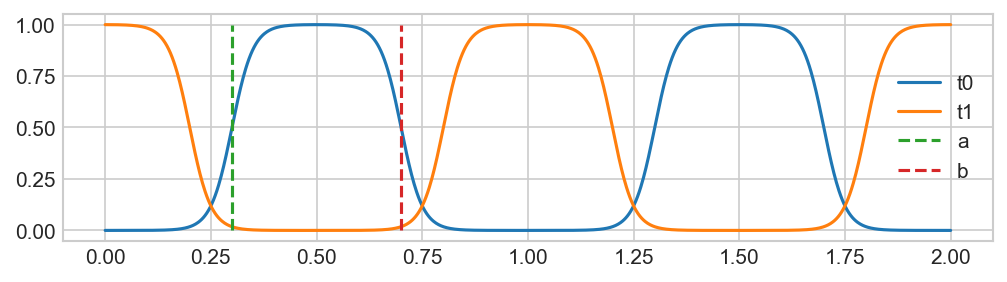

In [18]:
phase_indicator_pair = self.phase_indicator_pair
a = phase_indicator_pair.a
b = phase_indicator_pair.b

t = np.linspace(0,2,1000)
e_i0,e_i1 = phase_indicator_pair.get(t)

fig, ax= plt.subplots(1,1 ,figsize=(8,2),dpi=75)
ax.plot(t,e_i0,label="t0")
ax.plot(t,e_i1,label="t1")
ax.plot([a,a],[0,1],'--',label='a')
ax.plot([b,b],[0,1],'--',label='b')
plt.legend(loc='best', frameon=False)

In [3]:
import numba
numba.NUMBA_CACHE_DIR

AttributeError: module 'numba' has no attribute 'NUMBA_CACHE_DIR'

In [4]:
import os
os.environ['NUMBA_CACHE_DIR']

KeyError: 'NUMBA_CACHE_DIR'

In [1]:
from robot_utils import *

In [2]:
from scipy.spatial.transform import Rotation
